# DS4400 Final Project 
# - Flight Customer Review Recommendation Precition
## (Natural Language Processing model)

## Group Member: Wenting Yue, Xiaofei Xie, Yuxi Shen

# Load Dataset

In [1]:
import pandas as pd
from textblob import TextBlob

df_flight = pd.read_csv("capstone_airline_reviews3.csv", encoding="utf-8", encoding_errors='ignore').dropna()
df_flight["airline"].unique()

array(['Turkish Airlines', 'Qatar Airways', 'Emirates', 'Lufthansa',
       'KLM Royal Dutch Airlines', 'Virgin America', 'American Airlines',
       'Delta Air Lines', 'Southwest Airlines', 'United Airlines',
       'Jetblue Airways', 'Aegean Airlines', 'Aeroflot Russian Airlines',
       'Aeromexico', 'Air Canada', 'Air New Zealand', 'Alitalia',
       'AirAsia', 'Asiana Airlines', 'Avianca', 'Austrian Airlines',
       'British Airways', 'Brussels Airlines', 'China Eastern Airlines',
       'China Southern Airlines', 'Copa Airlines', 'Ethiopian Airlines',
       'Egyptair', 'Finnair', 'Iberia', 'ANA All Nippon Airways',
       'easyJet', 'Korean Air', 'LATAM Airlines', 'LOT Polish Airlines',
       'Qantas Airways', 'Air France', 'Etihad Airways',
       'Pegasus Airlines', 'Royal Jordanian Airlines', 'Ryanair',
       'South African Airways', 'Saudi Arabian Airlines', 'TAP Portugal',
       'Eurowings', 'EVA Air', 'Royal Air Maroc', 'Singapore Airlines',
       'SAS Scandinavian', 

# Install Torch and import necessary libriaries

In [2]:
pip uninstall torch torchtext -y

Found existing installation: torch 2.0.0
Uninstalling torch-2.0.0:
  Successfully uninstalled torch-2.0.0
Found existing installation: torchtext 0.15.1
Uninstalling torchtext-0.15.1:
  Successfully uninstalled torchtext-0.15.1
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torch==1.9.0 torchtext==0.10.0

  Using cached torch-1.9.0-cp39-none-macosx_10_9_x86_64.whl (127.9 MB)
  Using cached torchtext-0.10.0-cp39-cp39-macosx_10_9_x86_64.whl (1.5 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.1 requires torch==2.0.0, but you have torch 1.9.0 which is incompatible.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.9.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install spacy

Note: you may need to restart the kernel to use updated packages.


In [5]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.8 MB 4.3 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [6]:
#!pip install --upgrade torchtext

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.legacy import data
from torchtext.legacy import datasets
from torchtext.datasets import IMDB
from sklearn.model_selection import train_test_split

In [8]:
df_nlp = df_flight[["customer_review", "recommended"]]
df_nlp.to_csv("flight_nlp.csv", index = False)
df_nlp = df_nlp.sample(2000)
df_nlp

,customer_review,recommended
46155,â Unverified | London Heathrow to Philadelph...,yes
13177,âœ… Verified Review | Amsterdam to Santiago wi...,yes
103623,This was the return sector from Hong Kong to M...,yes
117392,âœ… Verified Review | Hong Kong to Jakarta. I ...,yes
49911,Mumbai to Washington via Brussels. Onward fli...,no
...,...,...
5893,Dubai to Singapore. On this flight I started ...,yes
3591,Doha to Paris in August 2017. No amenity kit ...,no
56041,âœ… Verified Review | Traveled in business cla...,yes
47871,Glasgow to Cape Town via Heathrow with British...,no


# Create WordCload visualizations for preview

In [9]:
yes_reviews = df_flight[df_flight['recommended'] == 'yes']['customer_review']
no_reviews = df_flight[df_flight['recommended'] == 'no']['customer_review']

In [10]:
import re

def clean_text(text):
    # Regular expression to match special characters
    special_char_pattern = re.compile(r'[^a-zA-Z\s]')
    
    # Replace special characters and digits with a space
    cleaned_text = re.sub(special_char_pattern, ' ', text)
    
    # Convert the text to lowercase and split it into words
    words = cleaned_text.lower().split()
    
    # Remove any empty words
    words = [word for word in words if word]
    
    # Join the words back into a string separated by a single space
    return ' '.join(words)

yes_reviews_cleaned = yes_reviews.apply(clean_text)
no_reviews_cleaned = no_reviews.apply(clean_text)

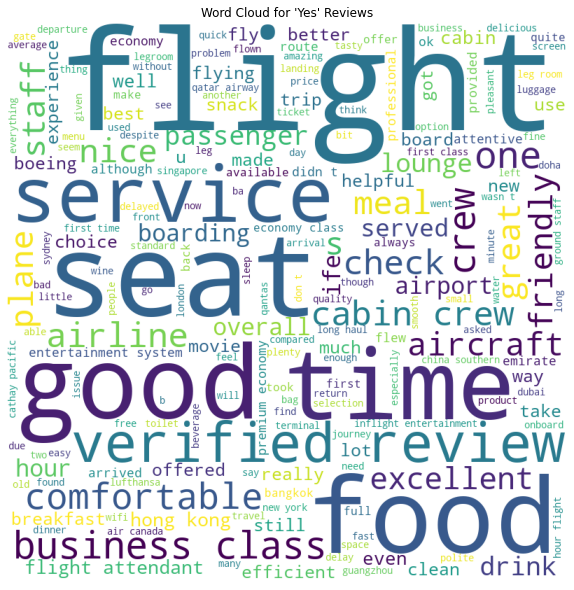

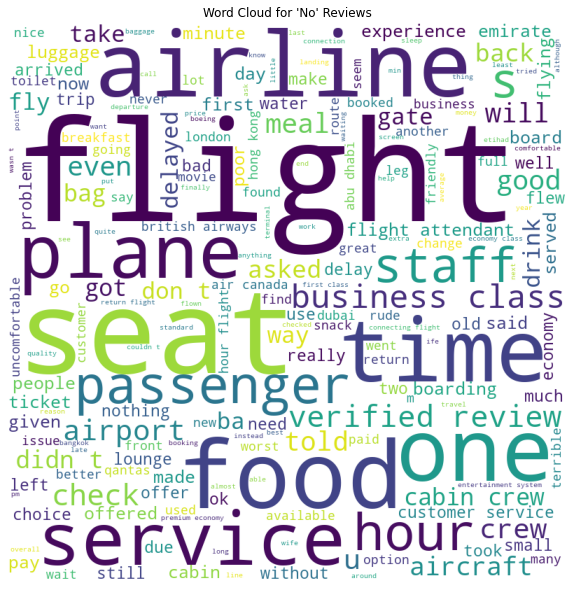

In [11]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
def create_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=None, min_font_size=10).generate(text)
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.tight_layout(pad=0)
    plt.show()

yes_reviews_text = ' '.join(yes_reviews_cleaned)
no_reviews_text = ' '.join(no_reviews_cleaned)

create_wordcloud(yes_reviews_text, "Word Cloud for 'Yes' Reviews")
create_wordcloud(no_reviews_text, "Word Cloud for 'No' Reviews")

In [13]:
import spacy
import re
from torchtext.legacy import data
# 2. Load and preprocess data:
nlp = spacy.load('en_core_web_sm')

def custom_tokenizer(text):
    special_char_pattern = re.compile(r'[^a-zA-Z0-9\s]')
    tokens = [token.text for token in nlp(text) if not token.is_stop]
    tokens = [re.sub(special_char_pattern, '', token) for token in tokens]
    tokens = [token for token in tokens if token]
    return tokens


# Define the fields
TEXT = data.Field(tokenize=custom_tokenizer, include_lengths=True)
LABEL = data.Field(sequential = False)

# # Load the dataset using TabularDataset
data_fields = [('customer_review', TEXT), ('recommended', LABEL)]
full_data = data.TabularDataset(path="flight_nlp.csv", format='csv', fields=data_fields, skip_header=True)

# Convert the dataset to a list of tuples
full_data_list = [(ex.customer_review, ex.recommended) for ex in full_data]

# Split the data using train_test_split
train_valid_data_list, test_data_list = train_test_split(full_data_list, test_size=0.2, random_state=42)
train_data_list, valid_data_list = train_test_split(train_valid_data_list, test_size=0.25, random_state=42)

# Convert the split data back to torchtext datasets
train_data = data.Dataset([data.Example.fromlist(example, data_fields) for example in train_data_list], data_fields)
valid_data = data.Dataset([data.Example.fromlist(example, data_fields) for example in valid_data_list], data_fields)
test_data = data.Dataset([data.Example.fromlist(example, data_fields) for example in test_data_list], data_fields)

print("First 5 examples from train_data:")
for example in train_data.examples[:5]:
    print("Review:", example.customer_review)        # Access the 'customer_review' attribute
    print("Recommended:", example.recommended)   # Access the 'recommended' attribute
    print("------")

TEXT.build_vocab(train_data, max_size=25000)
LABEL.build_vocab(train_data)

BATCH_SIZE = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    sort_within_batch=True,
    sort_key=lambda x: len(x.customer_review),
    device=device
)

First 5 examples from train_data:
Review: ['Verified', 'Review', 'YKA', 'YVR', 'SFO', 'July', '20th', 'SFO', 'YVR', 'YKA', 'July', '26th', 'travelled', 'Bay', 'Area', 'Kamloops', 'YKA', 'July', '20th', 'returned', 'July', '26th', 'flights', 'time', 'efficient', 'enjoyable', 'enjoyed', 'Air', 'Canada', 'Preferred', 'Seating', 'Premium', 'Economy', 'benefits', 'A319', 'way', 'A320', 'way', 'people', 'served', 'people', 'plane', 'extra', 'legroom', 'comfortable', 'seats', 'extra', 'space', 'neighbours', 'flights', 'San', 'Francisco', 'enjoyable', 'recommend', 'extra', 'small', 'fee', 'sit', 'preferred', 'seating', 'premium', 'economy', 'benefits', 'Air', 'Canada', 'flights', 'service', 'Kamloops', 'Vancouver', 'efficient', 'time', 'Air', 'Canada', 'main', 'choices', 'flights', 'mention', 'lot', 'frequent', 'flyer', 'points', 'signed', 'Star', 'Alliance']
Recommended: yes
------
Review: ['Flight', 'Cape', 'Town', 'late', 'Dubai', 'traffic', 'parked', 'different', 'terminal', 'connecting', 

In [14]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        embedded = self.dropout(self.embedding(text))

        # Pack the sequence to remove paddings
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), enforce_sorted=False)
        packed_output, (hidden, cell) = self.rnn(packed_embedded)

        # Unpack the sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        # Concatenate the last hidden state from forward and backward LSTM (if bidirectional)
        if self.rnn.bidirectional:
            hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        else:
            hidden = hidden[-1, :, :]

        return self.fc(self.dropout(hidden))
    
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 3
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)

In [15]:
# 4. Initialize and train the model:
import torch.optim as optim

# Define the optimizer and the loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Move the model and criterion to the device
model = model.to(device)
criterion = criterion.to(device)

# Define the training function
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        optimizer.zero_grad()
        text, text_lengths = batch.customer_review
        predictions = model(text, text_lengths).squeeze(1)

        # Convert the target labels to float
        targets = batch.recommended#.float()

        loss = criterion(predictions, targets)
        acc = categorical_accuracy(predictions, targets)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def categorical_accuracy(preds, y):
    max_preds = preds.argmax(dim=1, keepdim=True)  # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    acc = correct.sum() / torch.FloatTensor([y.shape[0]]).to(device)
    return acc

N_EPOCHS = 5

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc*100:.2f}%')

Epoch: 01, Train Loss: 0.642, Train Acc: 67.58%
Epoch: 02, Train Loss: 0.479, Train Acc: 77.38%
Epoch: 03, Train Loss: 0.396, Train Acc: 82.76%
Epoch: 04, Train Loss: 0.339, Train Acc: 86.15%
Epoch: 05, Train Loss: 0.316, Train Acc: 86.83%


In [16]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.customer_review
            predictions = model(text, text_lengths).squeeze(1)

            # Convert the target labels to float
            targets = batch.recommended#.float()

            loss = criterion(predictions, targets)
            acc = categorical_accuracy(predictions, targets)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
print(f'Validation Loss: {valid_loss:.3f}, Validation Acc: {valid_acc*100:.2f}%')

Validation Loss: 0.618, Validation Acc: 81.44%


In [23]:
#6. 

import spacy
nlp = spacy.load("en_core_web_sm")

def spacy_tokenizer(text):
    return [token.text for token in nlp.tokenizer(text)]

def predict_sentiment(model, text, tokenizer):
    model.eval()
    tokens = tokenizer(text)
    token_indices = [TEXT.vocab.stoi[token] for token in tokens]
    text_length = torch.tensor([len(token_indices)]).to(device)
    token_tensor = torch.tensor(token_indices).unsqueeze(1).to(device)
    prediction = model(token_tensor, text_length)
    predicted_class = prediction.argmax(dim=1).item()
    return predicted_class

# Example sentiment prediction
# 2 is not recommended, 1 is recommended
text = 'horrible flight'
sentiment = predict_sentiment(model, text, spacy_tokenizer)

print(f"Sentiment score: {sentiment}")

Sentiment score: 2
